<a href="https://colab.research.google.com/github/barauna-lo/SAMBATimes/blob/main/RFI_Dection_in_Pulsars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdution of the Problem

# Libraries

In [1]:
import numpy as np
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.timeseries import LombScargle
from scipy.signal import periodogram
import warnings

In [2]:
#And some useful functions that we will use later
def plotSpectrum(spectra,freqs):
    plt.plot(freqs,np.average(spectra,axis=0))
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Counts")
    plt.show()
    
def plotLC(spectra,periodogram=False,doScatter=False,plotlim=[]):
    if len(plotlim)>0:
        ind_min=int(plotlim[0]/dt)
        ind_max=int(plotlim[1]/dt)
    else:
        ind_min=0
        ind_max=len(spectra)-1
        
    times=np.linspace(0,(len(spectra)-1)*dt,len(spectra))
    times=times[ind_min:ind_max]
    intensities=np.nanmean(spectra,axis=1)
    intensities=intensities[ind_min:ind_max]
    if doScatter:
        plt.scatter(times,intensities)
    else:
        plt.plot(times,intensities)
    plt.xlabel("Time [s]")
    plt.ylabel("Counts")
    plt.show()
    
    
    if periodogram:
        freq, p_ls = LombScargle(times, np.nan_to_num(intensities)).autopower(minimum_frequency=0.000000001,
                                         maximum_frequency=10,
                                         normalization='psd',
                                         samples_per_peak=50)
        plt.plot(freq,p_ls)
        plt.yscale("log")
        plt.xlabel("Frequency")
        plt.ylabel("Spectral Power")
        plt.show()
        
        return freq, p_ls
    
    
    return times,intensities
    
def getStokesI(data):
    spectra = []
    mjds = []
    phi=0 #reference angle for Q-U reference frame

    #we need to convert the data to total intensity
    #since the data are recorded in circular polarization
    for i in range(len(data)):
        spectrum=[]

        mjds.append(data[i][0])

        #extract polarization parameters
        lcp=np.array(data[i][1][0])
        rcp=np.array(data[i][1][1])
        COS=np.array(data[i][1][2])
        SIN=np.array(data[i][1][3])

        I=lcp+rcp
        Q=np.cos(phi)*COS-np.sin(phi)*SIN
        U=np.sin(phi)*COS+np.cos(phi)*SIN
        V=lcp-rcp   


        spectra.append(I)#append STOKES I (Q=1,U=2,V=3)

    return np.array(spectra)
    
#Define the Gaussian function
def Gauss(x, A, B, C, D):
    y = A*np.exp(-1*B*(x-C)**2)+D
    return y
    
#does a simple bandpass calibration by dividing all data by the average spectrum
def calibrateBandpass(spectra):
    for i in range(len(spectra[0])):
        add_count=0
        for j in range(len(spectra)):
            add_count+=spectra[j][i]
        corr_factor=add_count/len(spectra)
        for j in range(len(spectra)):
            spectra[j][i]=spectra[j][i]/corr_factor
            
    return spectra

def removeNoiseCal(spectra,showPlots=False,removeSource=False):
    
    #remove noise cal effect 
    for j in tqdm(range(len(spectra[0]))):

        #seperate the two/four phases
        bin1=[]
        bin2=[]
        count=2
        switch=True
        for i in range(len(spectra)):
            if count==0:
                switch=not switch 
                count=2
            if switch:
                bin1.append(spectra[i][j])
            elif not switch:
                bin2.append(spectra[i][j])
            count-=1

        if removeSource:
            try:
                parameters1, covariance1 = curve_fit(Gauss, np.arange(len(bin1)), np.array(bin1),p0=np.asarray([0.1,1/100,len(bin1)/2,np.average(bin1)]),maxfev = 2000)
            except:
                parameters1=[0,0,0,0]
            try:    
                parameters2, covariance2 = curve_fit(Gauss, np.arange(len(bin2)), np.array(bin2),p0=np.asarray([0.1,1/100,len(bin2)/2,np.average(bin2)]),maxfev = 2000)
            except:
                parameters2=[0,0,0,0]

            fit_A1 = parameters1[0]
            fit_B1 = parameters1[1]
            fit_C1 = parameters1[2]
            fit_D1 = parameters1[3]
            fit_A2 = parameters2[0]
            fit_B2 = parameters2[1]
            fit_C2 = parameters2[2]
            fit_D2 = parameters2[3]

            fit1 = Gauss(np.arange(len(bin1)), fit_A1, fit_B1, fit_C1, fit_D1)
            fit2 = Gauss(np.arange(len(bin2)), fit_A2, fit_B2, fit_C2, fit_D2)
        else:
            fit1 = np.full(len(bin1),np.average(bin1))
            fit2 = np.full(len(bin2),np.average(bin2))


        if showPlots:
            plt.scatter(np.arange(len(bin1)),bin1)
            plt.plot(np.arange(len(bin1)),fit1,color="yellow")
            plt.scatter(np.arange(len(bin2)),bin2)
            plt.plot(np.arange(len(bin2)),fit2,color="red")
            plt.show()
        
        
        bin1=bin1-fit1
        bin2=bin2-fit2

        final_time=[]
        i=0
        while i<len(bin1):
            final_time.append(bin1[i])
            if not i+1>=len(bin1):
                final_time.append(bin1[i+1])
            if not i>=len(bin2):
                final_time.append(bin2[i])
            if not i+1>=len(bin2):
                final_time.append(bin2[i+1])
            i+=2


        #plt.scatter(np.arange(len(final_time)),final_time)
        #plt.show()

        for i in range(len(spectra)):
            spectra[i][j]=final_time[i]
    return spectra

#two simple functions for RFI removal (courtesy of H. Shetgaonkar)

def get_robust_mean_rms(input_arr, sigma_threshold):
    arr = np.copy(input_arr)
    ok = False
    iter_i, rms, mean = 0, 0.0, 0.0
    while not ok:
        iter_i += 1
        threshold = rms * sigma_threshold

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean = np.nanmean(arr)
        rms0 = rms

        if iter_i > 1:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                arr[abs(arr - mean) > threshold] = np.nan
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            rms = np.nanstd(arr)

        if iter_i > 1:
            if rms == 0.0:
                ok = True  # return
            elif np.isnan(rms):
                ok = True
            elif abs((rms0 / rms) - 1.0) < 0.01:
                ok = True
        print(f"mean={mean} ----> rms={rms}")
    return mean, rms

def remove_rfi(dynamic_spectrum, sigma_threshold=3):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        mean, rms = np.nanmean(dynamic_spectrum, axis=0), np.nanstd(dynamic_spectrum, axis=0)
    
    # option for robust mean/rms
    snr = 0.5 #float(np.sqrt(1))
    efficiency_x = mean / rms * snr
    
    mean_x, std_x = get_robust_mean_rms(efficiency_x, sigma_threshold)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        flagged_ds = np.where(abs(mean_x - efficiency_x) > sigma_threshold * std_x, np.nan, dynamic_spectrum)

    return flagged_ds

## Load the Data

In [3]:
#Effelsberg data TELAMON
filename = "S20mm-SPECPOL-ARRAYDATA-1.fits"
telamon_data_fits = fits.open(filename)

## Let's inspect the data - See all the informations

In [4]:
#View FITS tables
telamon_data_fits.info()

Filename: S20mm-SPECPOL-ARRAYDATA-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  ARRAYDATA-MBFITS    1 BinTableHDU     90   1776R x 2C   [D, 4096E]   


In [5]:
#The data are stored in Table 1, so let's inspect that further
telamon_data_fits[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                16392 / width of table in bytes                        
NAXIS2  =                 1776 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
EXTNAME = 'ARRAYDATA-MBFITS'   / name of this binary table extension            
GRPID1  =                   -1 / EXTVER of Group containing this HDU            
GRPLC1  = '../GROUPING.fits'   / URL of file containing Group                   
LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.
COMMENT   This FITS file may

In [6]:
#Let's extract some important information
scantime = 28 #scantime in seconds (not included in header)
bandwidth = telamon_data_fits[1].header["BANDWID"]
center_freq = telamon_data_fits[1].header["RESTFREQ"]
low_freq=center_freq-bandwidth/2
high_freq=center_freq+bandwidth/2

#and read out the data
data = telamon_data_fits[1].data
#convert data from circular Polarization to StokesI
spectra = getStokesI(data)

#extract some information
dt=scantime/len(spectra) #time sampling
freqs=np.linspace(low_freq/1e9,high_freq/1e9,len(spectra[0]))

## Data Vizualization & Basic Calibration


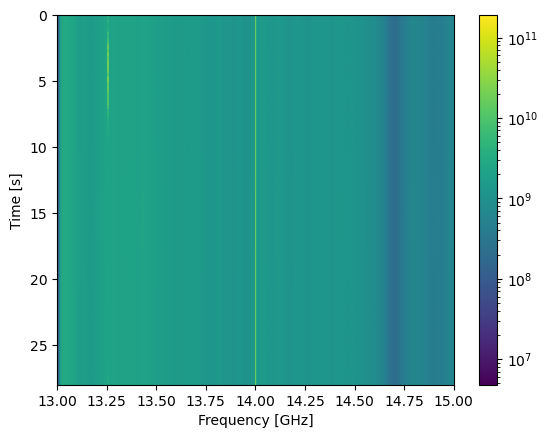

In [7]:
# Now that we have imported the data, let's plot it
# First, let's start with a simple waterfall plot
plt.imshow(spectra,norm=colors.LogNorm(),extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

Before Bandpass calibration


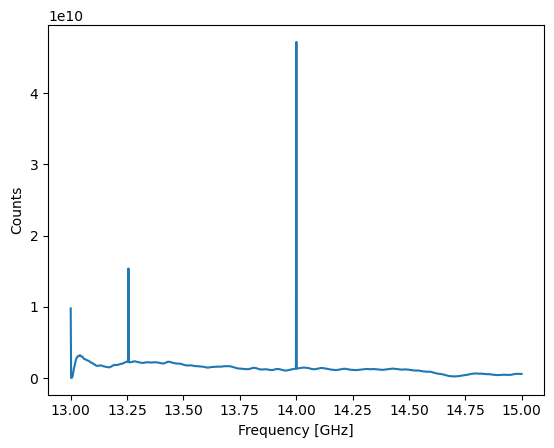

After Bandpass calibration


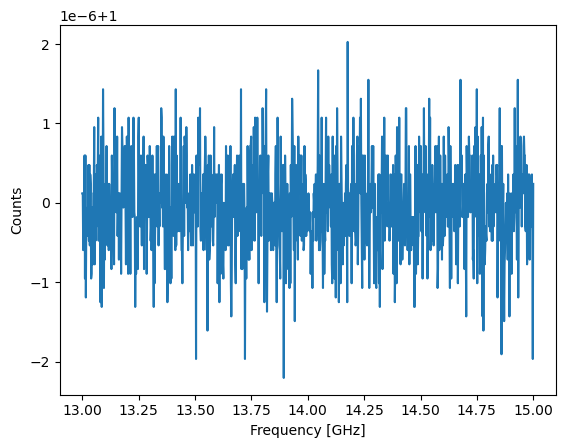

In [8]:
#Let's also look at the spectrum summed over time
print("Before Bandpass calibration")
plotSpectrum(spectra,freqs)

#We need to correct for the bandpass (different sensitivy for different frequencies), let's do this
print("After Bandpass calibration")
spectra=calibrateBandpass(spectra)
#Now check again the spectrum
plotSpectrum(spectra,freqs)

Before Noisecal Correction


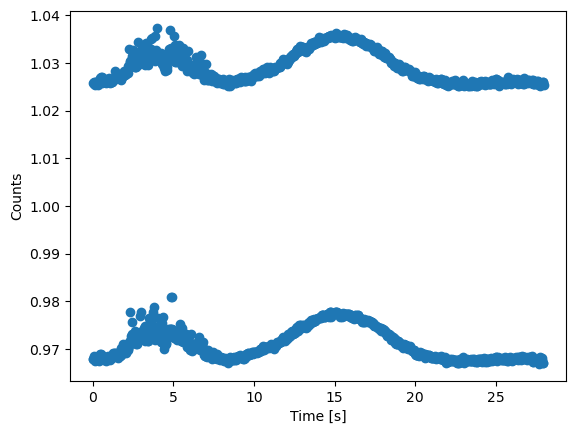

After Noisecal correction


100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 931.23it/s]


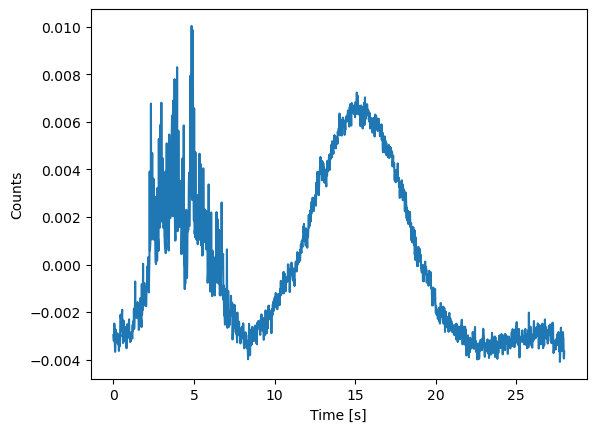

Blazar subtracted


  0%|                                                  | 0/1024 [00:00<?, ?it/s]/tmp/ipykernel_10002/2557929589.py:75: RuntimeWarning: overflow encountered in exp
  y = A*np.exp(-1*B*(x-C)**2)+D
100%|██████████████████████████████████████| 1024/1024 [00:04<00:00, 208.15it/s]


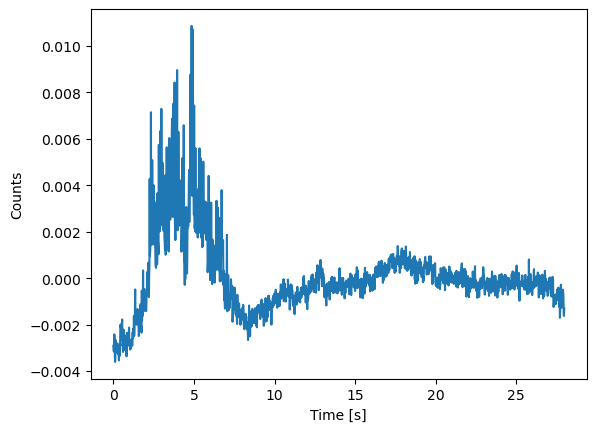

(array([0.00000000e+00, 1.57657658e-02, 3.15315315e-02, ...,
        2.79369369e+01, 2.79527027e+01, 2.79684685e+01]),
 array([-0.00291064, -0.00309544, -0.00315485, ..., -0.00158149,
        -0.00162319, -0.00131016], dtype=float32))

In [9]:
#And the "lightcurve", summed over all frequencies
print("Before Noisecal Correction")
plotLC(spectra,doScatter=True)

#We have to remove a Noise Diode effect from the data
print("After Noisecal correction")
spectra=removeNoiseCal(spectra)
plotLC(spectra)

#And we can also remove the Blazar Target since we are not interested in it for this project (we are looking for transients!)
print("Blazar subtracted")
spectra=removeNoiseCal(spectra,removeSource=True)
plotLC(spectra)

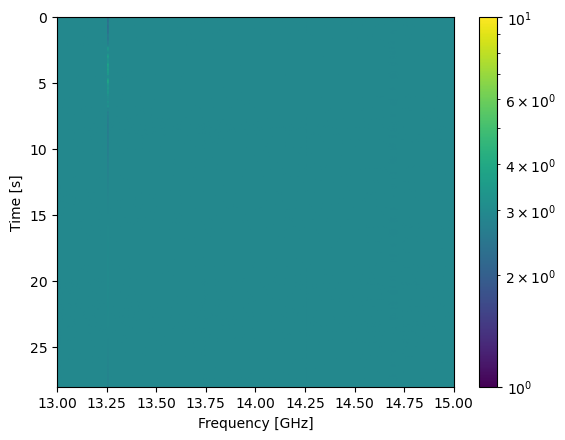

In [10]:
#let's shift it to counts>0
spectra=spectra-np.min(spectra)
#Let's look at the waterfaller plot again
plt.imshow(spectra,norm=colors.LogNorm(vmin=1,vmax=10),extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

# Clean RFI in the charts

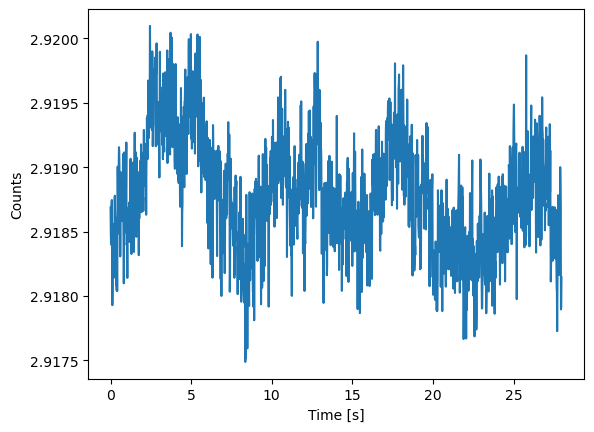

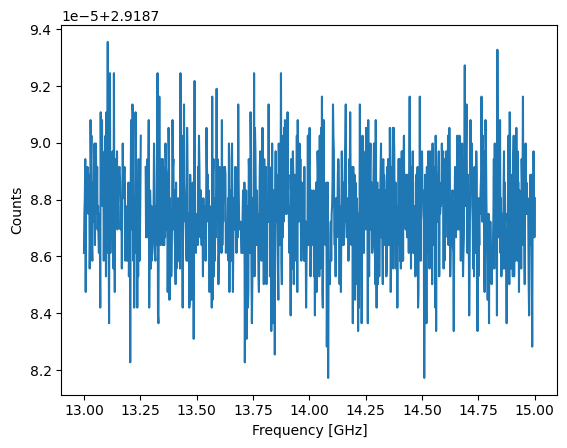

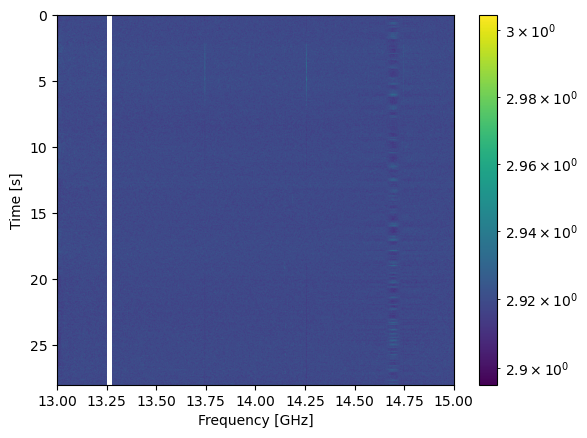

In [11]:
# Let's try to get rid of the most prominent RFI components and clean the scan
# First, let's try a simple manual flagging where we exclude the brightest visible RFI channel
mask=np.zeros(spectra.shape)
mask[:,130:140]=1
spectra_masked=np.ma.masked_array(spectra,mask)

#Let's plot the LC again and the spectrum to see what changed
plotLC(spectra_masked)
plotSpectrum(spectra_masked,freqs)

#Waterfall plot
plt.imshow(spectra_masked,norm=colors.LogNorm(),extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

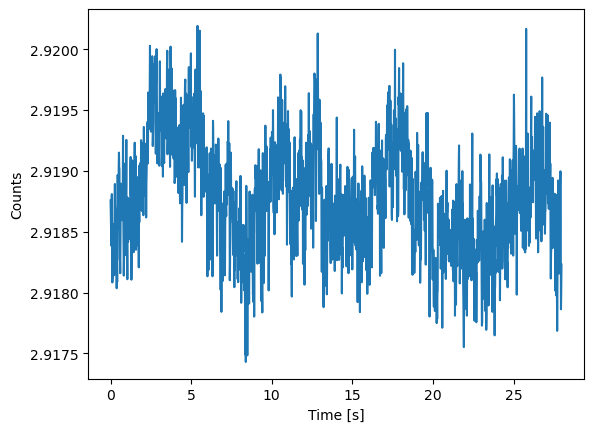

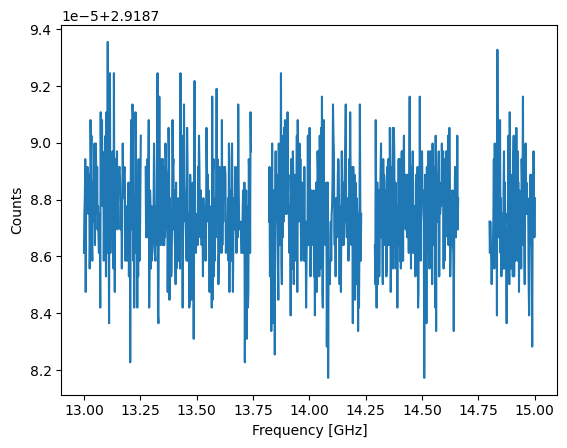

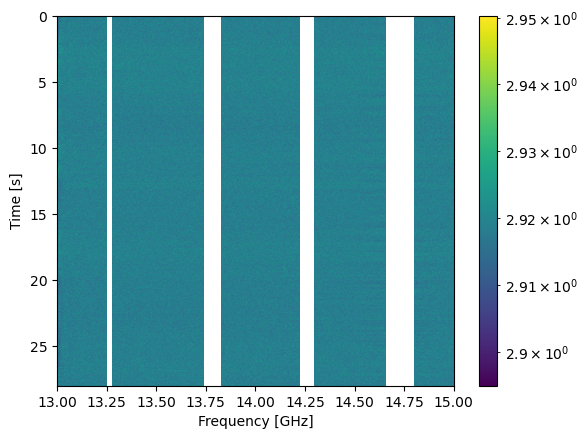

In [12]:
#Still we see a lot of RFI-like signals, let's see if we can get rid of more of them
mask[:,850:920]=1
mask[:,630:660]=1
mask[:,380:420]=1
spectra_masked2=np.ma.masked_array(spectra_masked,mask)

plotLC(spectra_masked2)
plotSpectrum(spectra_masked2,freqs)

#Waterfall plot
plt.imshow(spectra_masked2,norm=colors.LogNorm(),extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

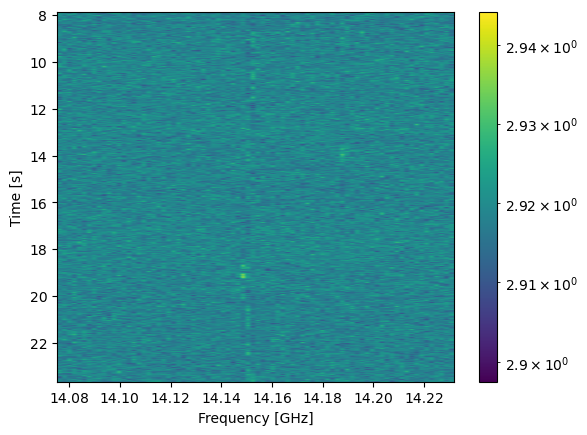

In [13]:
#Looks better but still not perfect, for instance if we zoom in a bit, we see there is still a lot of RFI signal
#-> all of this is quite tedious to get rid of manually, so we need some more powerful tools!
plt.imshow(spectra_masked2[500:1500,550:630],norm=colors.LogNorm(),extent=[freqs[550],freqs[630],scantime*1500/len(spectra),scantime*500/len(spectra)],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

mean=305.43017578125 ----> rms=25.831693649291992
mean=305.43017578125 ----> rms=13.160810470581055
mean=306.45111083984375 ----> rms=10.807042121887207
mean=307.0716857910156 ----> rms=10.067858695983887
mean=306.8997802734375 ----> rms=9.882631301879883
mean=306.83380126953125 ----> rms=9.882631301879883


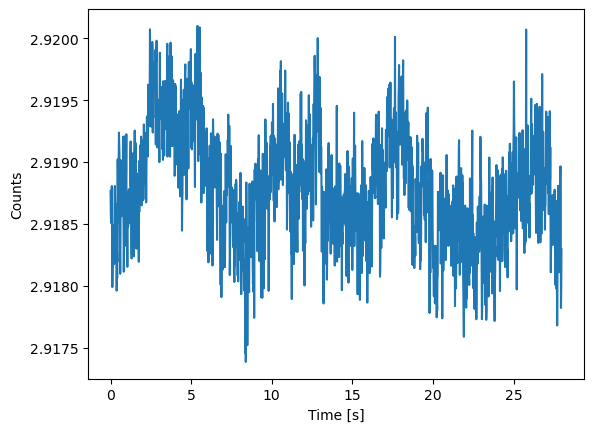

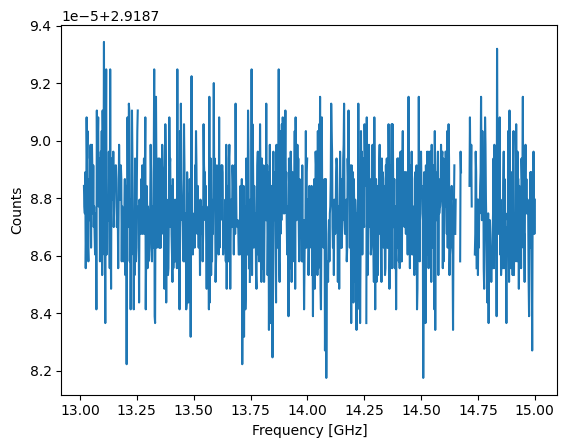

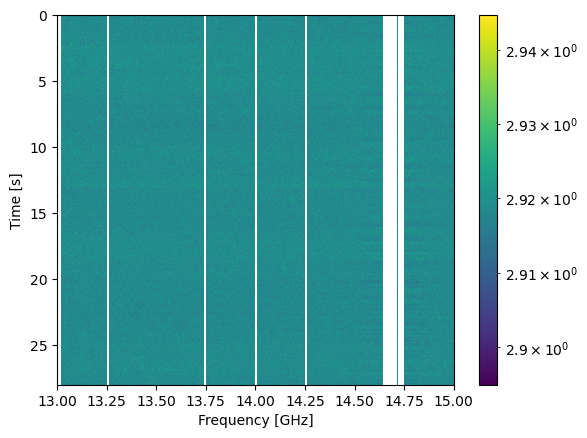

In [14]:
#Let's try a bit more sophisticated RFI removal using the functions introduced at the beginning 
#rms based flagging
cleaned_spectra=remove_rfi(spectra)

#and plot it
plotLC(cleaned_spectra)
plotSpectrum(cleaned_spectra,freqs)

#Waterfall plot
plt.imshow(cleaned_spectra,norm=colors.LogNorm(),extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

# Let's look at some UIRAPURU data

In [15]:
#UIRAPURU data 
filename = "UIRAPURU_20230203_082000_59.fit"
uirapuru_data_fits = fits.open(filename)

#View FITS tables
uirapuru_data_fits.info()

#View Header Info
header=uirapuru_data_fits[0].header

#read out some basic information
date_obs=header["DATE-OBS"].replace("/","-")+"T"+header["TIME-OBS"]
date_end=header["DATE-END"].replace("/","-")+"T"+header["TIME-END"]
scantime=Time(date_end)-Time(date_obs)
scantime=scantime.sec #get scantime in seconds
dt=scantime/float(header["NAXIS1"])

header

Filename: UIRAPURU_20230203_082000_59.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (1800, 400)   uint8   
  1                1 BinTableHDU     16   1R x 2C   [1800D8.3, 400D8.3]   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1800 / length of data axis 1                          
NAXIS2  =                  400 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT  File created by e-Callisto for Unix version 1.1.0                      
DATE    = '2023-02-03'         / Time of observation                            
CONTENT = '2023/02/03  Radio flux density, e-CALLISTO (UIRAPURU)' / Title of ima
ORIGIN  = 'PB_BRA  '           / Organization name                              
TELESCOP= 'Radio Spectromete

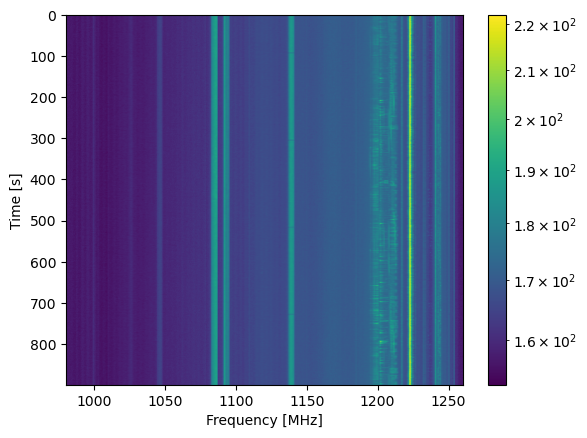

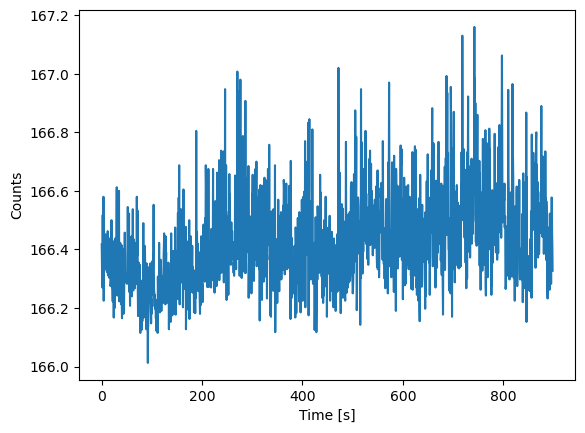

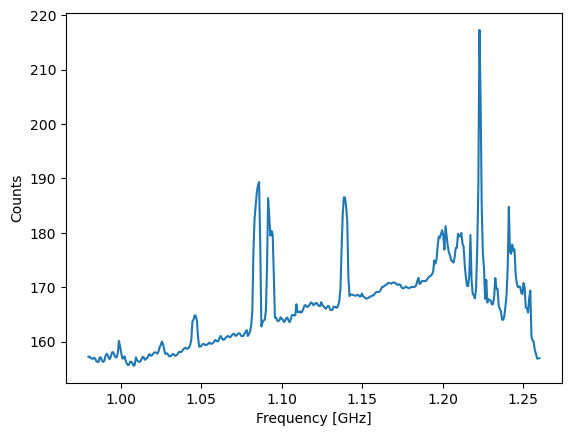

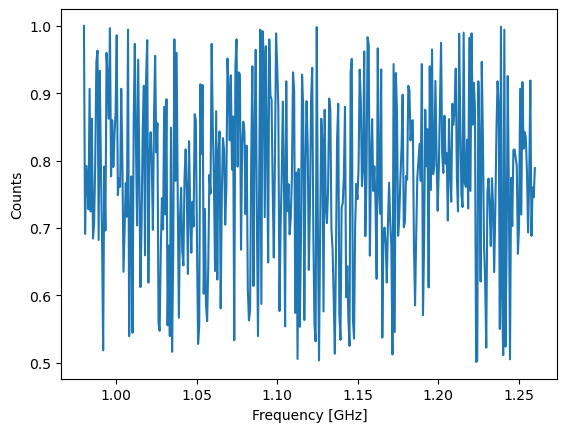

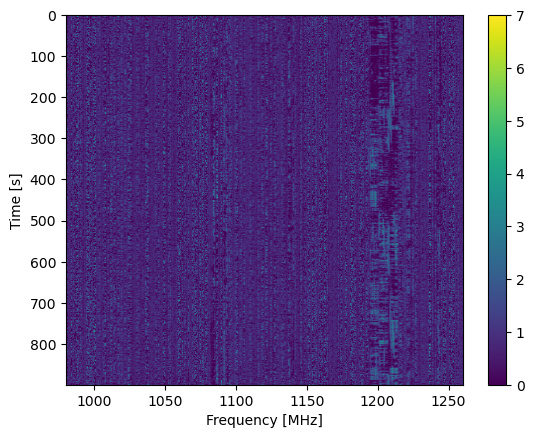

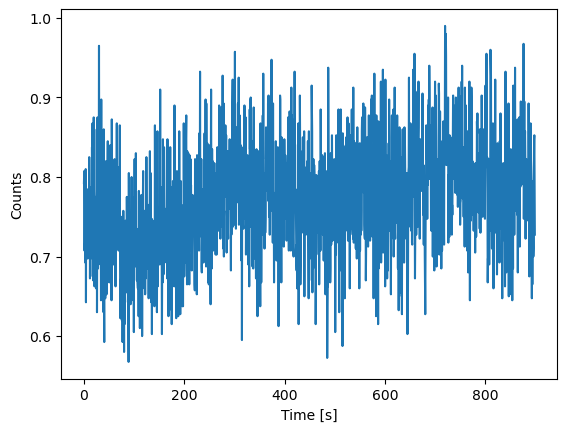

(array([0.00000000e+00, 4.99703889e-01, 9.99407778e-01, ...,
        8.97468184e+02, 8.97967888e+02, 8.98467592e+02]),
 array([0.7925, 0.8075, 0.7075, ..., 0.8525, 0.79  , 0.7275]))

In [16]:
image_data=np.transpose(uirapuru_data_fits[0].data)

"""
#let's try with a fake transient -> we play with this later
image_data[500:510,100:200]=image_data[500:510,100:200]+2
"""

plt.imshow(image_data,norm=colors.LogNorm(),extent=[980,1260,scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()

plotLC(image_data)
plotSpectrum(image_data,np.linspace(0.98,1.26,len(image_data[0])))
image_data_bandpass=calibrateBandpass(image_data)
image_data_bandpass=calibrateBandpass(image_data)
image_data_bandpass=calibrateBandpass(image_data)
plotSpectrum(image_data_bandpass,np.linspace(0.98,1.260,len(image_data[0])))
plt.imshow(image_data_bandpass,extent=[980,1260,scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()
plotLC(image_data_bandpass)

mean=0.5300206537538337 ----> rms=0.21387577052647164
mean=0.5300206537538337 ----> rms=0.21387577052647164


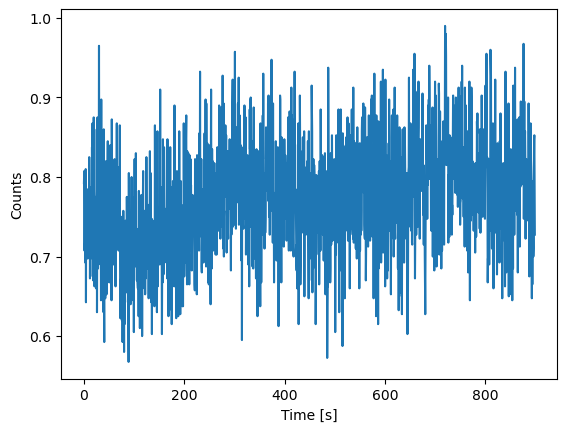

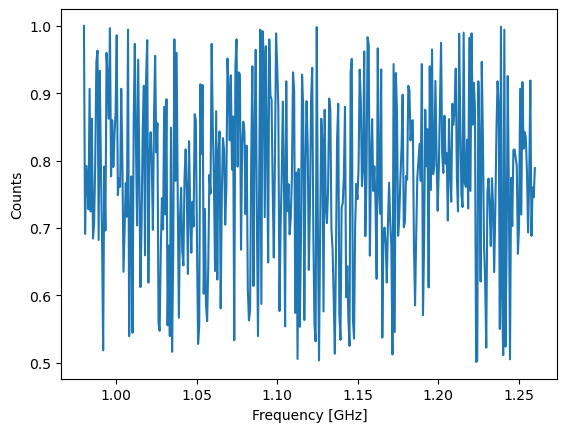

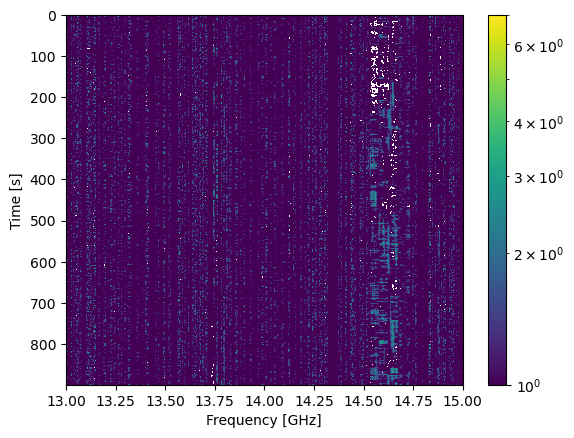

In [17]:
# you can see, here it is quite challenging to recover any sensible data because of the complex RFI environment
#let's try with automatic rfi flagging...
cleaned_spectra=remove_rfi(image_data_bandpass)

#and plot it
plotLC(cleaned_spectra)
plotSpectrum(cleaned_spectra,np.linspace(0.98,1.260,len(image_data[0])))

#Waterfall plot
plt.imshow(cleaned_spectra,norm=colors.LogNorm(),extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

# Effelsberg Data with a real astrophysical signal

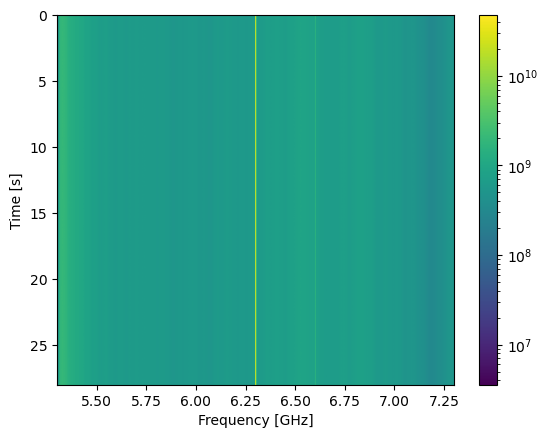

In [18]:
#Effelsberg data TELAMON with Pulsar Data
filename = "S45mm-SPECPOL-ARRAYDATA-1.fits"
telamon_data_fits = fits.open(filename)

#extract info
scantime = 28 #scantime in seconds (not included in header)
bandwidth = telamon_data_fits[1].header["BANDWID"]
center_freq = telamon_data_fits[1].header["RESTFREQ"]
low_freq=center_freq-bandwidth/2
high_freq=center_freq+bandwidth/2

#and read out the data
data = telamon_data_fits[1].data
#convert data from circular Polarization to StokesI
spectra = getStokesI(data)

#extract some information
dt=scantime/len(spectra) #time sampling
freqs=np.linspace(low_freq/1e9,high_freq/1e9,len(spectra[0]))

# Now that we have imported the data, let's plot it
# First, let's start with a simple waterfall plot
plt.imshow(spectra,norm=colors.LogNorm(),extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

intensities=np.average(spectra,axis=1)

100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 899.07it/s]


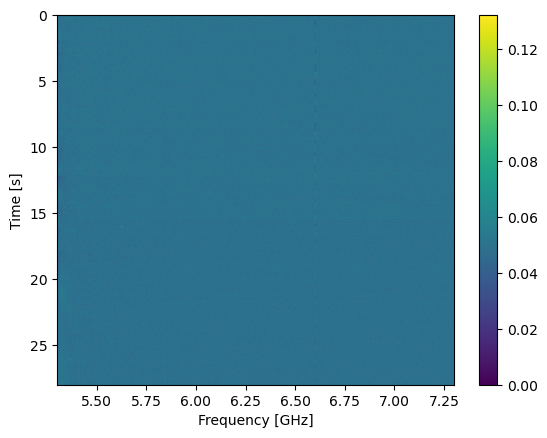

In [19]:
#Let's do all the preliminary calibration steps we learned about before

#Calibrate the Bandpass
spectra=calibrateBandpass(spectra)

#Remove Noisecal
spectra=removeNoiseCal(spectra)

#shift spectrum to positive values
#let's shift it to counts>0
spectra=spectra-np.min(spectra)

#Now plot again the Waterfaller 
plt.imshow(spectra,extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

mean=5.2693772315979 ----> rms=0.5179742574691772
mean=5.2693772315979 ----> rms=0.4694298207759857
mean=5.277557849884033 ----> rms=0.46321314573287964
mean=5.281916618347168 ----> rms=0.4613424837589264


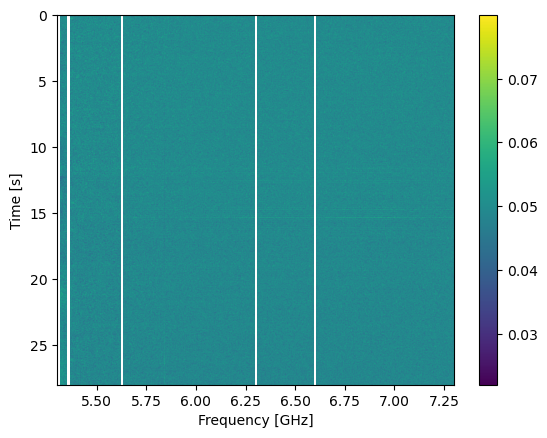

In [20]:
#lets try some manual masking (try out different options)
mask=np.zeros(spectra.shape)
mask[:,650:680]=1
mask[:,160:190]=1
mask[:,0:20]=1#mask the first couple of channels
spectra_masked=np.ma.masked_array(spectra,mask)

#or lets try some automatic flagging
spectra_masked=remove_rfi(spectra)

#Now plot again the Waterfaller 
plt.imshow(spectra_masked,extent=[np.min(freqs),np.max(freqs),scantime,0],aspect="auto")
plt.colorbar()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Time [s]")
plt.show()

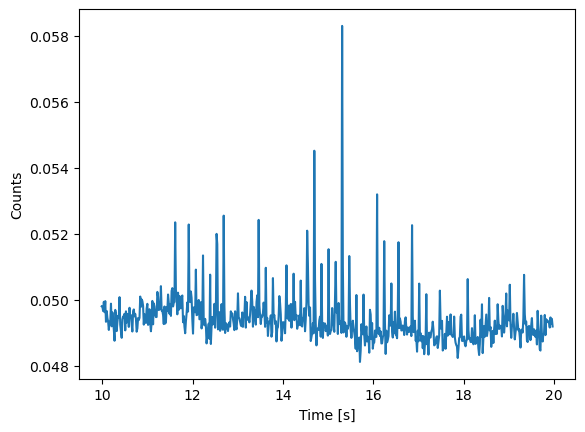

In [21]:
#It's not perfect yet but now we can look at the Light Curve again
times,counts=plotLC(spectra_masked,plotlim=[10,20])

## Now let's take a look at a periodogram to identify the period of the pulsar

Text(0, 0.5, 'Power Spectral Density')

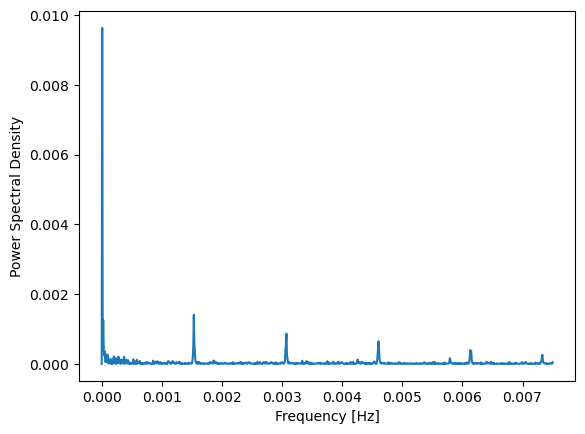

In [22]:
intensities=np.average(spectra,axis=1)

x,y=periodogram(intensities,0.015)
plt.plot(x,y)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")

# How can we generalize this and detect not only periodic events but also transients (FRBs)?
There are a lot of pulsar analysis packages (mostly C-based) which use sophisticated algorhithms to tackle all of these problems. 

If we have time we can look at some of these programs in a virtual machine:
- PRESTO
- TransientX

Possible problems for the data sets we looked at today:
- different data formats -> need to convert the fits files to PSRFITS standard or filterbank files
- very bad time sampling in TELAMON and UIRAPURU data: usually pulsar data comes in much better time- (and frequency-) resolution, therefore some methods from the pulsar world might not be applicable to the data sets we looked at today!